# Breast Cancer Dataset

## Wisconsin Breast Cancer Database Information

### Nombre d'attributs
- 10 attributs + 1 attribut de classe (11 colonnes au total).

### Attributs détaillés
1. **Sample code number**: Identifiant unique de l'échantillon.
2. **Clump Thickness**: Épaisseur des amas (valeurs de 1 à 10).
3. **Uniformity of Cell Size**: Uniformité de la taille des cellules (valeurs de 1 à 10).
4. **Uniformity of Cell Shape**: Uniformité de la forme des cellules (valeurs de 1 à 10).
5. **Marginal Adhesion**: Adhésion marginale (valeurs de 1 à 10).
6. **Single Epithelial Cell Size**: Taille des cellules épithéliales simples (valeurs de 1 à 10).
7. **Bare Nuclei**: Noyaux nus (valeurs de 1 à 10).
8. **Bland Chromatin**: Chromatine terne (valeurs de 1 à 10).
9. **Normal Nucleoli**: Nucléoles normaux (valeurs de 1 à 10).
10. **Mitoses**: Mitose (valeurs de 1 à 10).
12. **Class**: Classe (2 pour bénin, 4 pour malin).

### Informations complémentaires
- **Nombre d'instances**: 699
- **Valeurs manquantes**: 16 instances avec des valeurs manquantes, représentées par "?".


## Méthodologie de Sélection de Variables

Nous allons comparer trois approches de sélection de variables afin d'améliorer la performance de la classification :

### 1. **Recherche exhaustive** (Exhaustive Search)
Nous testons toutes les combinaisons possibles d'attributs pour identifier la meilleure sélection en fonction de plusieurs métriques (accuracy, F1-score, précision). Cette approche est coûteuse en temps de calcul mais garantit d'identifier l'ensemble optimal de variables.

### 2. **Sélection séquentielle avant (SFS Forward)**
Nous commençons avec un seul attribut et ajoutons progressivement ceux qui améliorent le plus la performance du modèle.

### 3. **Sélection séquentielle arrière (SFS Backward)**
Nous commençons avec tous les attributs et supprimons progressivement ceux qui ont le moins d'impact sur la performance.

# KNN (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec KNN 

In [2]:
import pandas as pd
import time 
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_knn = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_knn

    start_time = time.time()
    
    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])
    data = data.iloc[:, 1:]  # Supprimer la colonne d'identifiant
    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/safae/Documents/PIC/results_breast-cancer.xlsx', index=False)
    global_results_df_knn = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")


     # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")
    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv', header=None)

# Initialisation du modèle KNN
classifier = KNeighborsClassifier(n_neighbors=3)

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_knn.head())

C:\Users\safae\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\safae\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\safae\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\safae\anaconda3\Lib\site-packag

Best mean accuracy: 0.9599
Best mean f1-score: 0.9601
Best mean precision: 0.9606
Temps d'exécution : 1190.09 secondes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   feature8  feature9  mean_accuracy  mean_f1_score  mean_precision  \
0         0         0       0.000000       0.000000        0.000000   
1         0         0       0.818312       0.813358        0.861997   
2         0         0       0.902718       0.904570        0.918740   
3         0         0       0.915594       0.916486        0.922364   
4         0         0       0.659514       0.605

## SFS (backward + forward), accuracy_score, KNN

C:\Users\safae\AppData\Local\Temp\ipykernel_1700\3172833862.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   |     |     |     | ✔   | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   | ✔   |     |     | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   | ✔   |     |     | ✔   | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9599
Score SFS Forward : 0.9524
Score SFS Backward : 0.9667
Gap2 SFS Forward : 0.0134 | Gap2 SFS Backward : 0.0045


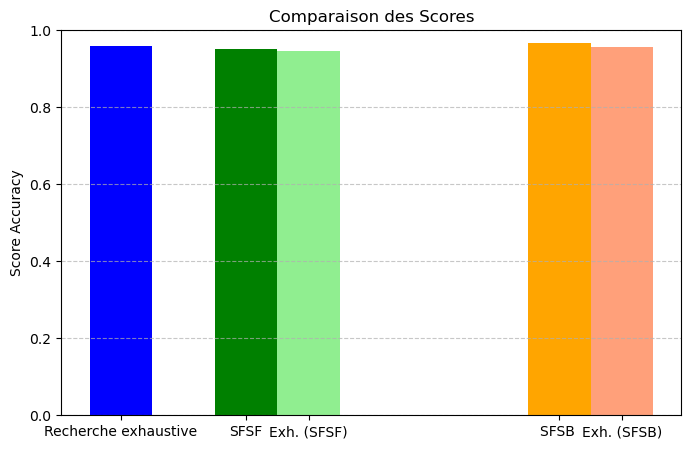

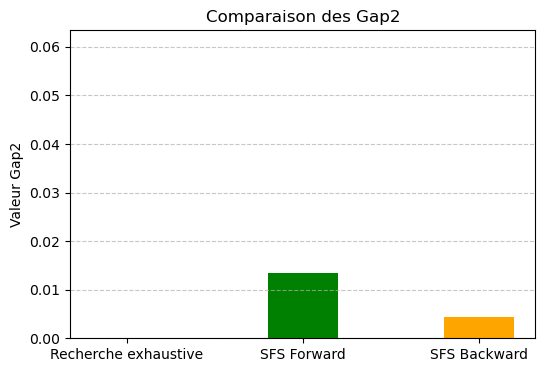

Temps d'exécution : 8.40 secondes


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])
    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant
    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score Accuracy', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1_score, KNN

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   |     |     |     | ✔   | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   | ✔   |     |     | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   | ✔   |     |     | ✔   | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9601
Score SFS Forward : 0.9324
Score SFS Backward : 0.9524
Gap2 SFS Forward : 0.0138 | Gap2 SFS Backward : 0.0046


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\1183713947.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


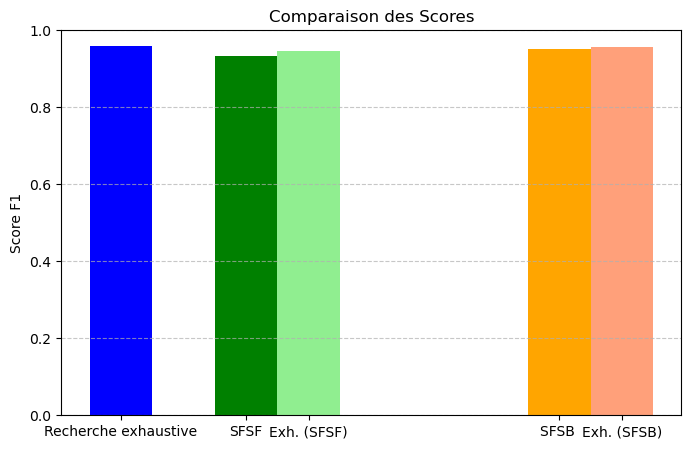

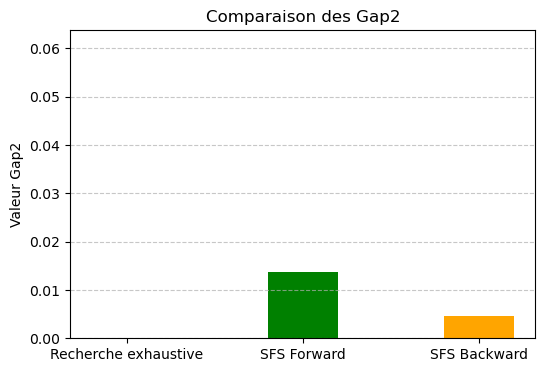

Temps d'exécution : 3.46 secondes


In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score F1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, KNN

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   |     |     |     | ✔   | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   | ✔   |     |     | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   | ✔   |     |     | ✔   | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9606
Score SFS Forward : 0.9200
Score SFS Backward : 0.9459
Gap2 SFS Forward : 0.0137 | Gap2 SFS Backward : 0.0050


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\2332328200.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


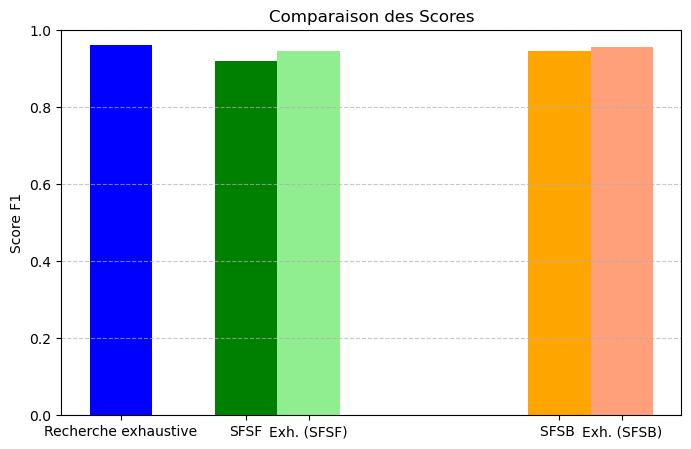

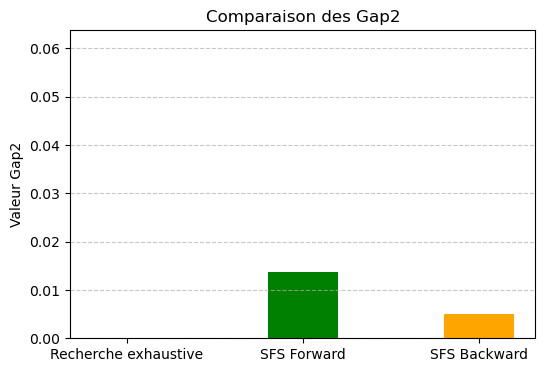

Temps d'exécution : 3.66 secondes


In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score F1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)


# XGB (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec XGB 

In [21]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_xgb = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_xgb

    start_time = time.time() #debut du chronometre
    
    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])
    data = data.iloc[:, 1:]  # Supprimer la colonne d'identifiant
    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/safae/Documents/PIC/results_breast_XGB_cancer.xlsx', index=False)
    global_results_df_xgb = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv', header=None)

# Initialisation du modèle KNN
classifier = XGBClassifier(eval_metric='logloss')

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_xgb.head())

Best mean accuracy: 0.9628
Best mean f1-score: 0.9629
Best mean precision: 0.9631
Temps d'exécution : 1131.15 secondes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   feature8  feature9  mean_accuracy  mean_f1_score  mean_precision  \
0         0         0       0.000000       0.000000        0.000000   
1         0         0       0.856938       0.849029        0.866683   
2         0         0       0.912732       0.912171        0.916902   
3         0         0       0.922747       0.922343        0.922393   
4         0         0       0.854077       0.849

## SFS (backward + forward), accuracy_score, XGB

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   |     | ✔   | ✔   | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   |     | ✔   |     |     |     |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     | ✔   | ✔   |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9628
Score SFS Forward : 0.9476
Score SFS Backward : 0.9810
Gap2 SFS Forward : 0.0015 | Gap2 SFS Backward : 0.0119


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\260120662.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


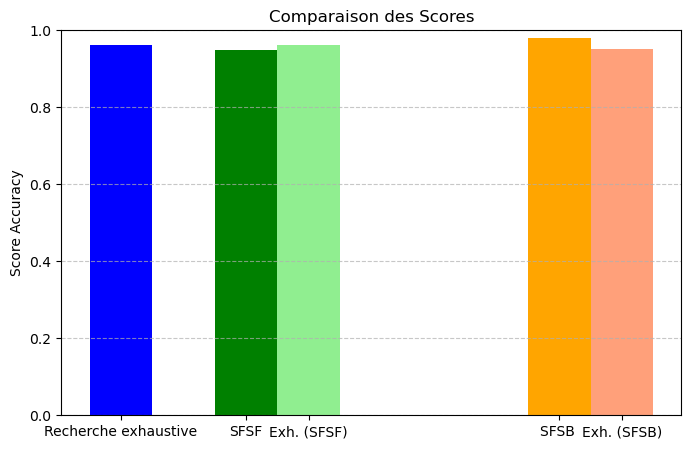

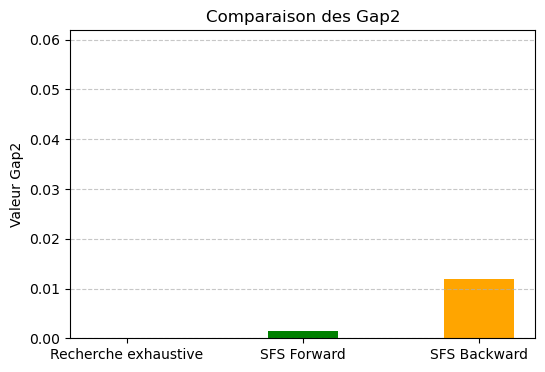

Temps d'exécution : 10.68 secondes


In [22]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score Accuracy', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1_score, XGB

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   |     | ✔   | ✔   | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   |     | ✔   |     |     |     |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     | ✔   | ✔   |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9629
Score SFS Forward : 0.9220
Score SFS Backward : 0.9730
Gap2 SFS Forward : 0.0016 | Gap2 SFS Backward : 0.0119


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\1152789936.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


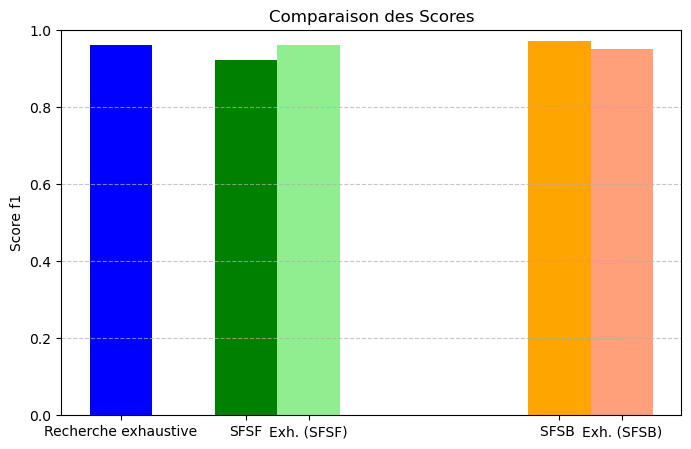

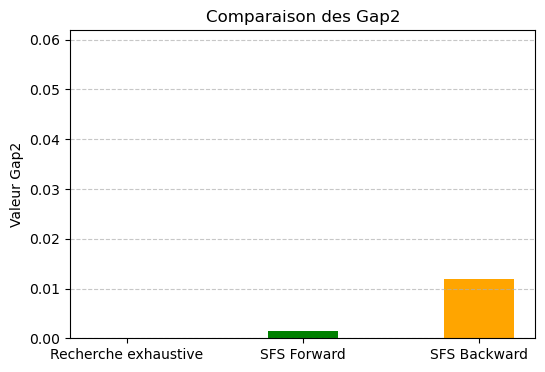

Temps d'exécution : 11.06 secondes


In [23]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, XGB

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   |     | ✔   | ✔   | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   |     | ✔   |     |     |     |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     | ✔   | ✔   |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9631
Score SFS Forward : 0.9559
Score SFS Backward : 0.9600
Gap2 SFS Forward : 0.0013 | Gap2 SFS Backward : 0.0111


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\107219497.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


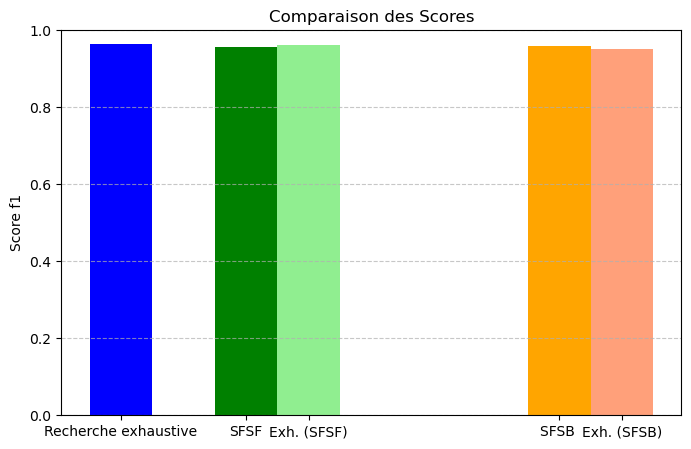

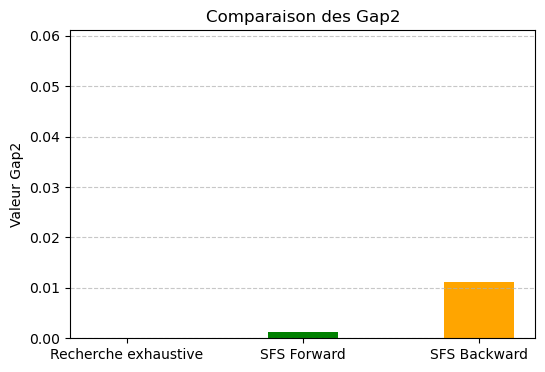

Temps d'exécution : 11.11 secondes


In [24]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    
    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)


# Logit (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec LogisticRegression 


In [14]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_logit = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_logit

    start_time = time.time() #debut du chronometre

    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    data = data.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/safae/Documents/PIC/results_LogReg_breast_cancer.xlsx', index=False)
    global_results_df_logit = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")

     # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")
    
    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv', header=None)

# Initialisation du modèle KNN
classifier = LogisticRegression(max_iter=1000)

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_logit.head())

Best mean accuracy: 0.9599
Best mean f1-score: 0.9600
Best mean precision: 0.9604
Temps d'exécution : 176.04 secondes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   feature8  feature9  mean_accuracy  mean_f1_score  mean_precision  \
0         0         0       0.000000       0.000000        0.000000   
1         0         0       0.861230       0.855657        0.864632   
2         0         0       0.927039       0.925727        0.927724   
3         0         0       0.922747       0.922343        0.922393   
4         0         0       0.854077       0.8497

## SFS (backward + forward), accuracy_score, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   | ✔   |     |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   | ✔   |     | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         |     | ✔   | ✔   |     |     | ✔   |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9599
Score SFS Forward : 0.9286
Score SFS Backward : 0.9286
Gap2 SFS Forward : 0.0194 | Gap2 SFS Backward : 0.0134


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\1679150766.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


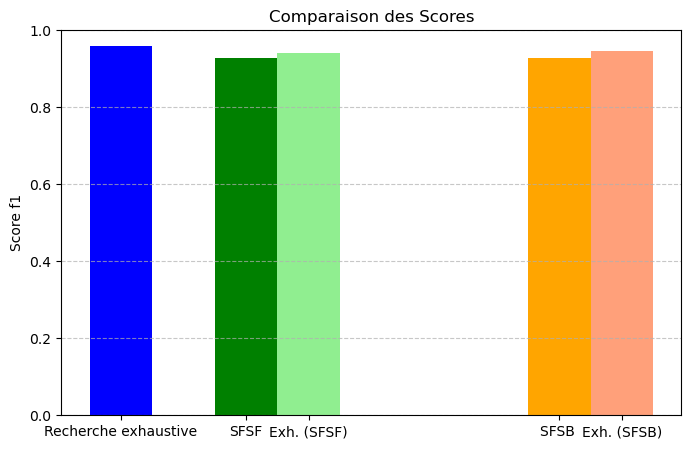

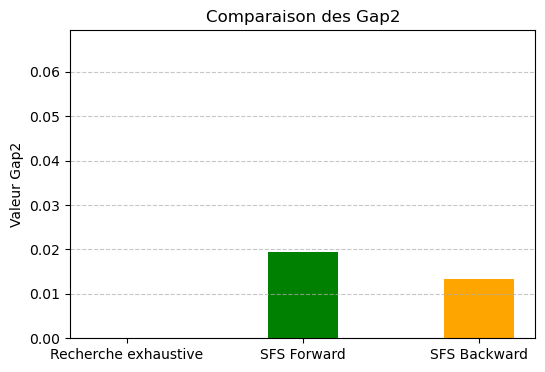

Temps d'exécution : 1.95 secondes


In [15]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   |     | ✔   |     | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   | ✔   |     | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         |     | ✔   | ✔   |     |     | ✔   |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9600
Score SFS Forward : 0.8921
Score SFS Backward : 0.8921
Gap2 SFS Forward : 0.0196 | Gap2 SFS Backward : 0.0135


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\362651958.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


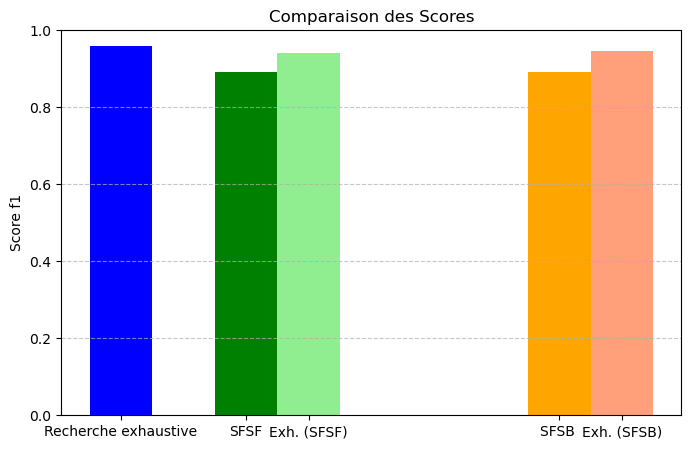

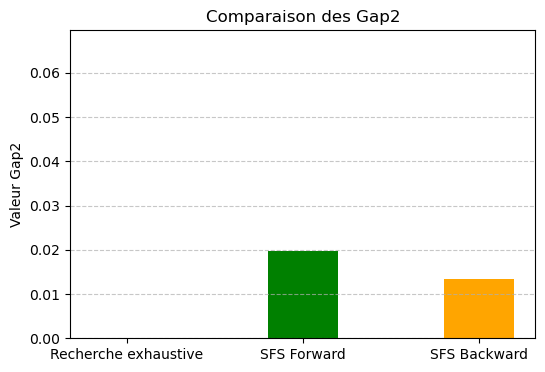

Temps d'exécution : 2.18 secondes


In [16]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   | ✔   |     |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   | ✔   |     | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         |     | ✔   | ✔   |     |     | ✔   |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9604
Score SFS Forward : 0.9394
Score SFS Backward : 0.9394
Gap2 SFS Forward : 0.0194 | Gap2 SFS Backward : 0.0137


C:\Users\safae\AppData\Local\Temp\ipykernel_1700\3429902410.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


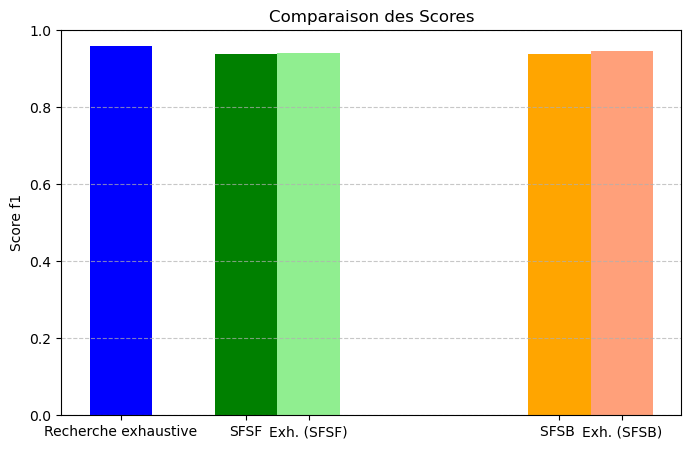

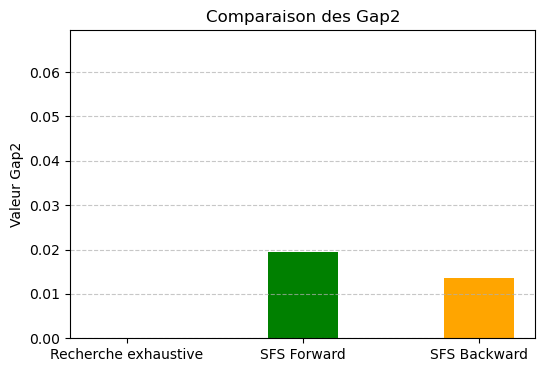

Temps d'exécution : 2.14 secondes


In [17]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    df = df.iloc[:, 1:]  # Supprimer la colonne d'identifiant

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/safae/Documents/PIC/breast+cancer+wisconsin+original/breast-cancer-wisconsin.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)
